# <span style="color:#3665af">SECTION 1: Big Graph Processing with GraphX </span>
<hr>

###### Goal
In this section, we will learn how to work with a graph-based distributed computation framework on Spark to read graph data and calculate graph properties including connected components. The datasets include metro.csv, country.csv and metro_country.csv. We want to create a graph that has metro and country as its vertices, where each edge connects a metro to the corresponding country. 
###### Prerequisites
This section has the following dependencies:
- Set up a small cluster loaded with Spark



To create your Dataproc Cluster, do the following:
1. We are assuming you still have a project in Google Cloud.
2. Go to Google Platform Dataproc and create a cluster with a master node (4vCPUs and 100 GB disk size). Two workers (2vCPUs and 100 GB disk size)
3. Go to storage and in Browser, create a bucket. Note: you have to choose a unique name for bucket. mybucket_graph as an example for bucket's name and you have to change it to your bucket's name in the instructions below.
4. Upload Data_files folder to this bucket 
5. Connect via SSH to the master node of the cluster

Copy the folder from storage bucket to the instance root:
    

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
gsutil cp -r gs://mybucket_graph/Data_files .
</pre>    

then if you use "ls", you will see this folder in the vm instance root

Now Upload the folder to the HDFS Hadoop:


<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
hdfs dfs -mkdir .
hdfs dfs -put ./Data_files
<pre>

Start the Spark Shell:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
spark-shell
</pre>

Start the Spark Shell with external library such as GraphStream: You should load all library with .jar in Data_files folder

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
spark-shell --jars Data_files/jcommon-1.0.16.jar,Data_files/gs-ui-1.2.jar,Data_files/breeze_2.10-0.9.jar,Data_files/pherd-1.0.jar,Data_files/breeze-viz_2.10-0.9.jar,Data_files/jfreechart-1.0.13.jar,Data_files/gs-core-1.2.jar
</pre>

###### Import the GraphX library
Set log level to error, suppress info and warn messages:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
import org.apache.log4j.Logger
import org.apache.log4j.Level
Logger.getLogger("org").setLevel(Level.ERROR)
Logger.getLogger("akka").setLevel(Level.ERROR)
</pre>

Import the Spark's GraphX and RDD libraries along with Scala's source library:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
import org.apache.spark.graphx._
import org.apache.spark.rdd._
import scala.io.Source
</pre>

First print first 5 lines of each file to check the input data:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
Source.fromFile("./Data_files/metro.csv").getLines().take(5).foreach(println)
</pre>

Output:

#metro_id,name,population

1,Tokyo,36923000
2,Seoul,25620000
3,Shanghai,24750000
4,Guangzhou,23900000

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
Source.fromFile("./Data_files/country.csv").getLines().take(5).foreach(println)
</pre>

Output:
#country_id,name

1,Japan
2,South Korea
3,China
4,India

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
Source.fromFile("./Data_files/metro_country.csv").getLines().take(5).foreach(println)
</pre>

Output:

#metro_id,country_id

1,1
2,2
3,3
4,3

Create case classes for the places (metros and countries):

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
class PlaceNode(val name: String) extends Serializable
<pre>

output: defined class PlaceNode

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
case class Metro(override val name: String, population: Int) extends PlaceNode(name)
</pre>

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
case class Country(override val name: String) extends PlaceNode(name)
</pre>

Read the comma delimited text file metros.csv into an RDD of Metro vertices:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
val metros: RDD[(VertexId, PlaceNode)] =
sc.textFile("./Data_files/metro.csv").
filter(! _.startsWith("#")).
map {line =>
val row = line split ','
(0L + row(0).toInt, Metro(row(1), row(2).toInt))
}
</pre>

output: metros: org.apache.spark.rdd.RDD[(org.apache.spark.graphx.VertexId, PlaceNode)] = MapPartitionsRDD[3] at map at <console>:39

Read the comma delimited text file country.csv into an RDD of Country vertices; ignore
lines that start with # and map the columns to: id, Country(name). Add 100 to the
country indexes so they are distinguished from the metro indexes.

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
val countries: RDD[(VertexId, PlaceNode)] =
sc.textFile("./Data_files/country.csv").
filter(! _.startsWith("#")).
map {line =>
val row = line split ','
(100L + row(0).toInt, Country(row(1)))
}
</pre>

###### Import the edges 

Read the comma delimited text file metro_country.tsv into an RDD[Edge[Int]] collection.
Remember to add 100 to the countries' vertex id

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
val mclinks: RDD[Edge[Int]] =
sc.textFile("./Data_files/metro_country.csv").
filter(! _.startsWith("#")).
map {line =>
val row = line split ','
Edge(0L + row(0).toInt, 100L + row(1).toInt, 1)
}
</pre>

###### Create the Graph

Concatenate the two sets of nodes into a single RDD.

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
val nodes = metros ++ countries
</pre>
<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
val metrosGraph = Graph(nodes, mclinks)
</pre>


<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 1
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
   
   Print the first 5 vertices.
Hint:  metrosGraph.vertices.take(5)
    </div>
</div>

<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 2
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
   
   Print the first 5 edges.

   </div>
</div>

<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 3
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
   
   Count the number of vertices and edges 
   
   Hint: metrosGraph.numEdges

   </div>
</div>

<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 4
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
   
   Create a new graph and add the continents. Concatenate the three sets of nodes into a single RDD. Concatenate the two sets of edges: Report the number of edges and vertices for the new graph
    </div>
</div> 

---
Import the graph stream library: 

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
import org.graphstream.graph.implementations._
</pre>

Create a new instance of SingleGraph:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
val countriesGraph = Graph(nodes, mclinks)
</pre>

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
val graph: SingleGraph = new SingleGraph("countriesGraph")
</pre>

Setup the visual Attributes:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
val stylesheet = """
graph {
    fill-color: white;
}

node {
    size: 20px, 20px;
    shape: box;    
    fill-color: black;
    stroke-mode: plain;
    stroke-color: red;
    text-visibility-mode:hidden;
}

edge {
    shape:line;
    fill-color:red;
    stroke-color:red;
}
"""

graph.addAttribute("ui.stylesheet", stylesheet)
graph.addAttribute("ui.quality")
graph.addAttribute("ui.antialias")</pre>

Load the GraphX vertices into GraphStream nodes:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
for ((id:VertexId, place:PlaceNode) &lt;- countriesGraph.vertices.collect())
{
val node = graph.addNode(id.toString).asInstanceOf[SingleNode]
node.addAttribute("name", place.name)
node.addAttribute("ui.label", place.name)
if (place.isInstanceOf[Metro])
node.addAttribute("ui.class", "metro")
else if(place.isInstanceOf[Country])
node.addAttribute("ui.class", "country")
else if(place.isInstanceOf[Continent])
node.addAttribute("ui.class", "continent")
}</pre>

Load GraphX edges: 

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
for (Edge(x,y,_) &lt;- countriesGraph.edges.collect()) {
graph.addEdge(x.toString ++ y.toString, x.toString, y.toString,
true).asInstanceOf[AbstractEdge]
}</pre>

<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 5
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
   
   Visualize the graph and report the num of connected components.

   Save your graph as an image:


   <pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
import org.graphstream.stream.file._

val out = new FileSinkImages(FileSinkImages.OutputType.PNG, FileSinkImages.Resolutions.HD720)

out.setLayoutPolicy(FileSinkImages.LayoutPolicy.COMPUTED_FULLY_AT_NEW_IMAGE);

out.writeAll(graph, "image.png")
    </pre>

   </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
        This will save your graph at /home/[username]/image.png. Use the "Download File" button to download this image. 
    </div>

</div>


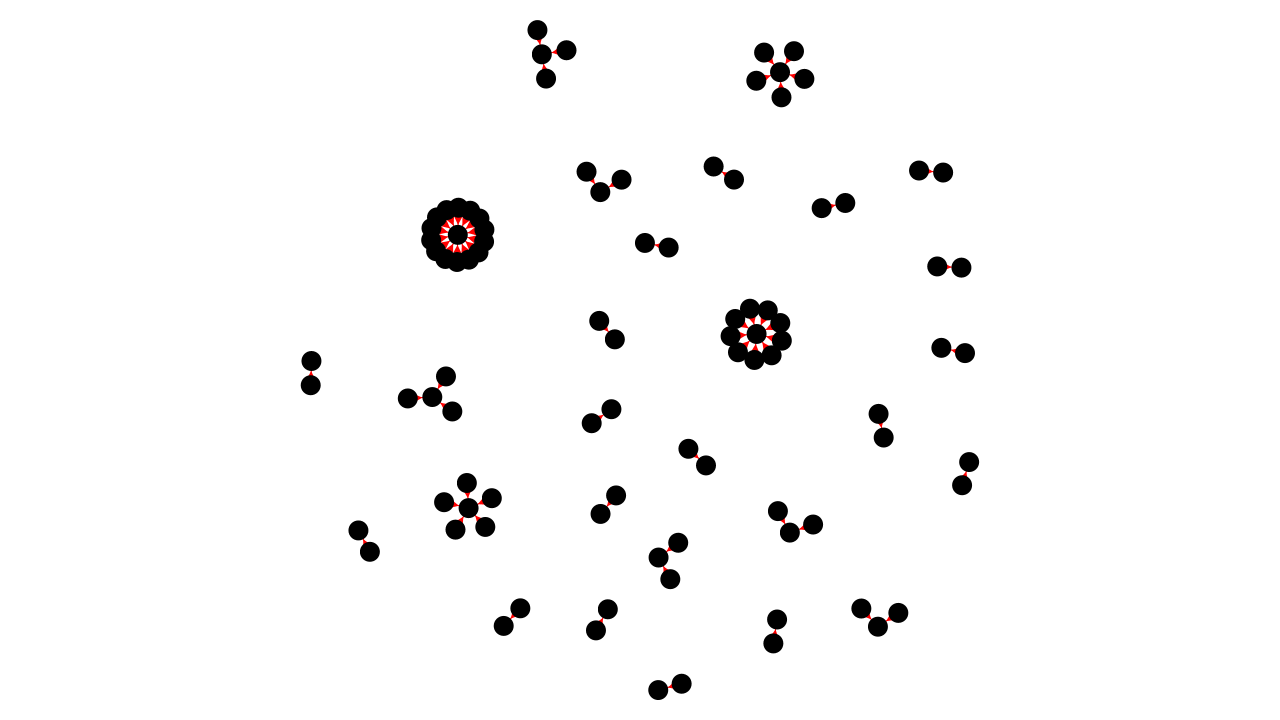

In [1]:
from IPython.display import Image
Image(filename='image.png')

<hr style="border-top: 5px solid purple; margin-top: 1px; margin-bottom: 1px"></hr>

***

# <span style="color:#3665af">SECTION 2: Graph Database: Neo4j </span>

***


###### Goal
In this section, we will learn how to work with a graph database.
###### Prerequisites
Install Neo4j:

Downloading, Installing, and Running Neo4j at:

https://neo4j.com/download-center/#desktop


Create a sample Graph (as an example): Attribute of node is toyNode and Attribute of relationship is ToyRelationship 

N1 - e1 -> N2

N2 - e2 -> N3

N2 - e3 -> N4

N1 - e4 -> N5

N4 - e5 -> N5

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
create (N1:ToyNode {name: 'Tom'}) - [:ToyRelation {relationship: 'knows'}] -&gt; (N2:ToyNode {name: 'Harry'}),
(N2) - [:ToyRelation {relationship: 'co-worker'}] -&gt; (N3:ToyNode {name: 'Julian', job: 'plumber'}),
(N2) - [:ToyRelation {relationship: 'wife'}] -&gt; (N4:ToyNode {name: 'Michele', job: 'accountant'}),
(N1) - [:ToyRelation {relationship: 'wife'}] -&gt; (N5:ToyNode {name: 'Josephine', job: 'manager'}),
(N4) - [:ToyRelation {relationship: 'friend'}] -&gt; (N5)
;</pre>

Display the graph:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
match (n:ToyNode)-[r]-(m) return n, r, m

This is how we select an existing single ToyNode node:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
match (n:ToyNode {name:'Julian'}) return n

Delete only ToyNode nodes which have no edges:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
match (n:ToyNode) delete n

Modify information of a Node:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
match (n:ToyNode) where n.name = 'Harry' set n.job = 'drummer'

match (n:ToyNode) where n.name = 'Harry' set n.job = n.job + ['lead guitarist'] </pre>

In the Neo4j Desktop active DBMS, click on three dot and hit Open folder -> import, then copy and paste the test.csv file there.
Load data from csv file test (source, target, distance):

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
LOAD CSV WITH HEADERS FROM "file:///test.csv" AS line

MERGE (n:MyNode {Name:line.Source})

MERGE (m:MyNode {Name:line.Target})

MERGE (n) -[:TO {dist:line.distance}]-&gt; (m)

<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 1
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
   Count the number of vertices

   </div>
</div>


Finding triangles:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
match (a)-[:TO]-&gt;(b)-[:TO]-&gt;(c)-[:TO]-&gt;(a)
return distinct a, b, c
</pre>

Finding paths between some selcted nodes:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
match p=(a)-[:TO*]-(c)
where a.Name='H' and c.Name='P'
return p limit 1</pre>

Find the shortest path between selected nodes:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
match p=shortestPath((a)-[:TO*]-(c))
where a.Name='A' and c.Name='P'
return p, length(p) limit 1</pre>

Find all Shortest Paths with Path Conditions:

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
MATCH p = allShortestPaths((source)-[:TO*]->(destination))
WHERE source.Name='A' AND destination.Name = 'P' AND LENGTH(p) > 5
RETURN [n IN NODES(p) | n.Name] AS Paths, LENGTH(p) AS PathLength
</pre>

Find degree histogram of the graph

<pre style="background-color: #ebece4;padding: 10px;border-left: solid 4px orange;">
match (n:MyNode)-[r]-()
with n as nodes, count(distinct r) as degree
return degree, count(nodes) order by degree asc
</pre>

***

<div style="font-size:20px;background-color:#0B6713;color:#F1E6E7;padding:10px;">
    TO-DO 1:
</div>
   
 #### Load assignment.csv file and follow these instructions in prepration for answering the following questions:

   

1. Define the node type to be TrialGene;
2. Add a Name property to the source node and assign the OFFICIAL_SYMBOL_A column values to it;
3. Add a Name property to the target node and assign the OFFICIAL_SYMBOL_B column values to it;
4. Define the edge type to be AssociationType;
5. Give each edge a property named AssociatedWith and assign the content of the column in the dataset with the heading EXPERIMENTAL_SYSTEM

<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 2
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
  Count the number of vertices and edges:

   </div>
</div>

<div style="width:100%;">
    <div style="width:15%;float:left;font-size:20px;background-color:#557aba;color:#eff3f9;padding:6px;font-wight:bold;text-align:center;">
    Question 3
    </div>
    <div style="width:85%;float:right;font-size:16px;background-color:#dce4f2;font-wight:normal;color:black;padding:6px;">
  Count how many shortest paths there are between the node named ‘BRCA1’ and the node named ‘NBR1’

   </div>
</div>

<hr style="border-top: 5px solid purple; margin-top: 1px; margin-bottom: 1px"></hr>